In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Convert an array of values into a dataset matrix.
def create_dataset(dataset, memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - memory - 1):
        a = dataset[i:(i + memory), 0]
        dataX.append(a)
        dataY.append(dataset[i + memory, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
# Loading data with column date as index.
# Folder.
dataset_folder="dataset"

# Dataset file
# It's very easy download from Yahoo finantial if you want data updated.
#filename="AMZN_2006-01-01_to_2018-01-01.csv"
filename="GOOGL_2006-01-01_to_2018-01-01.csv"
#filename="IBM_2006-01-01_to_2018-01-01.csv"

dataset = pd.read_csv(dataset_folder + "/" + filename, index_col='Date', parse_dates=True)

In [4]:
# Preview the data.
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [5]:
# Searching null values.
dataset.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [6]:
# Replacing null values by its mean value.
dataset.replace(np.NAN, dataset.mean(), inplace=True)

In [7]:
# Forecast between these dates
test_start_date = datetime.datetime.strptime('2017-01-01', '%Y-%m-%d')
test_end_date = datetime.datetime.strptime('2017-12-31', '%Y-%m-%d')

In [8]:
# Column to be selected.
column=1
data_set = dataset.iloc[:, column:column+1]

In [9]:
data_set

,High
Date,
2006-01-03,218.05
2006-01-04,224.70
2006-01-05,226.00
2006-01-06,235.49
2006-01-09,236.94
...,...
2017-12-22,1071.72
2017-12-26,1068.86
2017-12-27,1068.27


In [10]:
# We split the data into training and test sets.
training_set = data_set[:test_start_date - datetime.timedelta(1)]
test_set = data_set[test_start_date:test_end_date]

In [11]:
# Normalize between 0,1 the datasets.
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data_set)
data_set_scaled = scaler.transform(data_set)
training_set_scaled = scaler.transform(training_set)
test_set_scaled = scaler.transform(test_set)

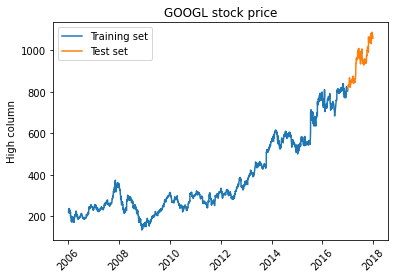

In [12]:
# Plotting training and test sets.
stock = filename.split("_",1)[0]
plt.plot(training_set)
plt.plot(test_set)
plt.title(stock + ' stock price')
plt.legend(['Training set', 'Test set'])
plt.ylabel(dataset.columns[column] + ' column')
plt.xticks(rotation=45)
plt.show()

In [13]:
# We define the memory for our LSTM.
memory = 20
X_train, y_train = create_dataset(training_set_scaled, memory)

In [14]:
# Checking the data shaping.
print(X_train.shape)
print('{:.8f}'.format(y_train[0]))
print(data_set_scaled[memory])
# Last digit must be the same.
print(X_train[1,:])

(2747, 20)
0.06975107
[0.06975107]
[0.0944445  0.09581052 0.10578247 0.1073061  0.10564586 0.10819927
 0.10813622 0.10388055 0.10545672 0.09886831 0.09682978 0.089758
 0.08363193 0.09234293 0.09721857 0.08973699 0.08880179 0.08620635
 0.08952683 0.06975107]


In [15]:
# Reshape input to be [samples=X_train.shape[0], time steps=X_train.shape[1], features=1].
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
X_train.shape

(2747, 20, 1)

In [17]:
# Design of the LSTM RNN.
# input_shape (batch_size: set up in the fitting phase as batch_size , time_steps, seq_len).

rnn_model = Sequential()

# Input layer.
rnn_model.add(LSTM(units=100, return_sequences=True, input_shape=(memory, 1)))

# Intermediate layers.
rnn_model.add(LSTM(units=50, return_sequences=False))
rnn_model.add(Dropout(0.1))

# Output layer.
rnn_model.add(Dense(units=1))

# Compiling.
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# Summary.
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Prepairing the memory for the first value (the last value of the traninig data set).
inputs = data_set_scaled[len(data_set) - len(test_set) - memory:len(data_set) - len(test_set) - 1]

In [20]:
inputs.shape

(19, 1)

In [21]:
# Fitting.
rnn_model.fit(X_train, y_train, epochs=10, batch_size=5)

Epoch 1/10
550/550 [==============================] - 5s 9ms/step - loss: 0.0011
Epoch 2/10
550/550 [==============================] - 5s 9ms/step - loss: 5.8266e-04
Epoch 3/10
550/550 [==============================] - 5s 9ms/step - loss: 5.2850e-04
Epoch 4/10
550/550 [==============================] - 5s 9ms/step - loss: 4.4139e-04
Epoch 5/10
550/550 [==============================] - 5s 9ms/step - loss: 3.9917e-04
Epoch 6/10
550/550 [==============================] - 5s 9ms/step - loss: 3.4941e-04
Epoch 7/10
550/550 [==============================] - 5s 9ms/step - loss: 2.9636e-04
Epoch 8/10
550/550 [==============================] - 5s 9ms/step - loss: 3.0710e-04
Epoch 9/10
550/550 [==============================] - 5s 9ms/step - loss: 2.6151e-04
Epoch 10/10
550/550 [==============================] - 5s 9ms/step - loss: 2.3759e-04


In [22]:
# We want a large forecast not only one day value.
predicted_stock_price_scaled = np.array(training_set_scaled[-1])
for i in range(len(test_set)):
    inputs = np.vstack([inputs, predicted_stock_price_scaled[i]])
    X_test = np.array(inputs[i:])
    X_test = np.reshape(X_test, (1, X_test.shape[0], 1))
    predicted_stock_price_scaled = np.vstack([predicted_stock_price_scaled, rnn_model.predict(X_test)])

predicted_stock_price = scaler.inverse_transform(predicted_stock_price_scaled[1:])

In [23]:
# Checking the first forecast value vs the first test value.
print(test_set.iloc[0].values)
print(predicted_stock_price[0])

[811.44]
[789.12670558]


In [24]:
predicted_set = pd.DataFrame(data=predicted_stock_price, index=test_set.index, columns=[column])

In [25]:
# 1day RNN, only ONE day predicted every step.
inputs = data_set_scaled[len(data_set)-len(test_set)-memory:]
inputs = inputs.reshape(-1,1)
X_test = []
for i in range(memory, inputs.shape[0]):
    X_test.append(inputs[i-memory:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_1day = rnn_model.predict(X_test)
predicted_stock_price_1day = scaler.inverse_transform(predicted_stock_price_1day)
predicted_set_1day = pd.DataFrame(data=predicted_stock_price_1day,
                                  index=test_set.index, columns=[column])

In [26]:
# Naive RNN, the next day predicted value is the today value.
predicted_set_naive = np.array(training_set[-1:].values)
predicted_set_naive = np.append(predicted_set_naive, test_set[0:-1].values)
predicted_set_naive = pd.DataFrame(data=predicted_set_naive, index=test_set.index, columns=[column])

In [27]:
# Testing the Naive data predicted is the data of the day before (first 5 rows).
np.stack((test_set, predicted_set_naive), axis=-1)[0:5,:]

array([[[811.44, 803.28]],

       [[813.43, 811.44]],

       [[813.74, 813.43]],

       [[828.96, 813.74]],

       [[830.43, 828.96]]])

In [28]:
# Holt-Winters algorithm running.
# Each year we have the same periods: summer holidays, Easter, Chrismas...
# We have 252 business days per year.
season=252

df = dataset.resample('B').mean().ffill()
df.index.freq = 'B'

train, test = df[:test_start_date - datetime.timedelta(1)].iloc[:,column], \
              df[test_start_date:test_end_date].iloc[:,column]

hw_model = ExponentialSmoothing(train, freq='B', trend='add', seasonal='mul', seasonal_periods=season).fit()
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

/home/davidglt/RNNvsHoltWinters/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [29]:
print(hw_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2869
Model:             ExponentialSmoothing   SSE                          94548.063
Optimized:                         True   AIC                          10539.570
Trend:                         Additive   BIC                          12065.770
Seasonal:                Multiplicative   AICC                         10590.775
Seasonal Periods:                   252   Date:                 Mon, 03 Aug 2020
Box-Cox:                          False   Time:                         22:19:19
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9999994                alpha                 True
smoothing_slope       

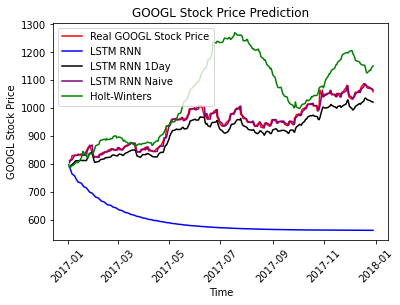

In [30]:
# Plotting the graphs.
plt.plot(test_set, color='red', label='Real ' + stock + ' Stock Price')
plt.plot(predicted_set, color='blue', label='LSTM RNN')
plt.plot(predicted_set_1day, color='black', label='LSTM RNN 1Day')
plt.plot(predicted_set_naive, color='purple', label='LSTM RNN Naive')
plt.plot(pred, color='green', label='Holt-Winters')
plt.title(stock + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock + ' Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [31]:
# Evaluating our models with RMSE.
rnn_rmse = math.sqrt(mean_squared_error(test_set, predicted_set))
rnn_rmse_1day = math.sqrt(mean_squared_error(test_set, predicted_set_1day))
rnn_rmse_naive = math.sqrt(mean_squared_error(test_set, predicted_set_naive))
hw_rmse = math.sqrt(mean_squared_error(test, pred))

print("The root mean squared error for 1-day Naive is {}.".format(rnn_rmse_naive))
print("The root mean squared error for 1-day RNN is {}.".format(rnn_rmse_1day))
print("The root mean squared error for RNN is {}.".format(rnn_rmse))
print("The root mean squared error for Holt-Winters is {}.".format(hw_rmse))

The root mean squared error for 1-day Naive is 9.182684228559433.
The root mean squared error for 1-day RNN is 35.16201633477673.
The root mean squared error for RNN is 370.0734281965321.
The root mean squared error for Holt-Winters is 136.56078082927093.


In [32]:
# Unload models from memory.
del rnn_model
del hw_model